# Predictions on Presidential Speeches

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from datetime import datetime, timedelta
import re
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

---
# Data Processing
## Load Raw Data
First, the data is loaded into a Pandas dataframe.

In [2]:
conn = sqlite3.connect('/Users/desiredewaele/Google Drive/Datasets/rawdata.sqlite')
rawData = pd.read_sql("select * from Speeches", conn)
rawData = rawData[rawData.president.str.contains(
    'Barack Obama|William J. Clinton|George W. Bush', regex=True)].sort_values('date', ascending=False)
#rawData = rawData[rawData.speech.str.contains('Weekly Address')]
rawData.tail()

,id,president,date,speech,title,text,notes,url
1282,3310,George W. Bush,"April 10, 2004",Weekly Address,The President's Radio Address,"Good morning. This week in Iraq, our coalition...",NOTE: The address was recorded at 8:50 a.m. on...,http://www.presidency.ucsb.edu/ws/index.php?pi...
1575,3603,William J. Clinton,"April 10, 1999",Weekly Address,The President's Radio Address,Good morning. Today I want to talk to you abou...,NOTE: The address was recorded at 12:50 p.m. o...,http://www.presidency.ucsb.edu/ws/index.php?pi...
1219,3247,George W. Bush,"April 1, 2006",Weekly Address,The President's Radio Address,Good morning. As tax day approaches later this...,NOTE: The address was recorded at 9:15 a.m. on...,http://www.presidency.ucsb.edu/ws/index.php?pi...
1526,3554,William J. Clinton,"April 1, 2000",Weekly Address,The President's Radio Address,Good morning. Today I want to speak with you a...,NOTE: The address was recorded at 12:38 p.m. o...,http://www.presidency.ucsb.edu/ws/index.php?pi...
1784,3812,William J. Clinton,"April 1, 1995",Weekly Address,The President's Radio Address,The President. | Good morning. I'm speaking t...,NOTE: The President spoke at 9:06 a.m. from th...,http://www.presidency.ucsb.edu/ws/index.php?pi...


## Tidy Data
The data is raw and we would like to tidy it up. The first function changes the dates into a sortable format. The second one strips the speech from capital letters, non-letter symbols and redundant whitespace.

In [3]:
def dateconverter(oldate):
    date = datetime.strptime(oldate, "%B %d, %Y")
    year = str(date.year); month = date.month; day = date.day
    if month < 10: month = "0" + str(month)
    else: month = str(month)
    if day < 10:day = "0" + str(day)
    else: day = str(day)
    date = year + "-" + month + "-" + day
    return date

In [4]:
    def textconverter(text):
        text = re.sub('\((.*?)\)', '', text)     # Removes all () parts
        text = re.sub('\[(.*?)\]', '', text)     # Removes all [] parts
        text = text.lower()                      # Change text to lowercase
        text = re.sub('[^(a-z)]| ', ' ', text)   # Change all not-text to spaces
        text = re.sub(' +',' ',text)             # Remove all redundant spaces
        text = text.strip()                      # Remove outer whitespace
        return text

We select the features we'll be working with, and apply both functions.

In [5]:
tidyData = rawData[['president','date','speech','text']]
tidyData.date = tidyData.date.apply(dateconverter)
tidyData.text = tidyData.text.apply(textconverter)
tidyData = tidyData.sort('date', ascending=True).reset_index(drop=True)
tidyData.tail(10)

,president,date,speech,text
1354,Barack Obama,2016-11-05,Weekly Address,hi everybody americans have been fighting for ...
1355,Barack Obama,2016-11-12,Weekly Address,hi everybody this weekend as we search for way...
1356,Barack Obama,2016-11-24,Weekly Address,hi everybody on behalf of the obama family mic...
1357,Barack Obama,2016-12-03,Weekly Address,hi everybody on the first day of my administra...
1358,Barack Obama,2016-12-10,Weekly Address,hi everybody it is the most wonderful time of ...
1359,Barack Obama,2016-12-17,Weekly Address,hi everybody if you ve ever played a game of b...
1360,Barack Obama,2016-12-24,Weekly Address,the president merry christmas everybody one of...
1361,Barack Obama,2016-12-31,Weekly Address,happy new year everybody at a time when we tur...
1362,Barack Obama,2017-01-07,Weekly Address,since the days of george washington presidents...
1363,Barack Obama,2017-01-14,Weekly Address,this week i traveled to chicago to deliver my ...


## Get Word Counts & Tfidfs Manually
To run k-means, we need to represent the speeches in some way. We do so with simple word counts, and the bit complexer [tfidfs](http://www.tfidf.com). To count the words, we create a dictionary, loop through all words in a speech, and add or increment the dictionary appropriately. 

In [ ]:
def wordCount(text):
    wordcount = dict()
    for word in text.split():
        if word in wordcount: wordcount[word] += 1
        else: wordcount[word] = 1
    return wordcount

In [ ]:
tidyData['wordcount'] = tidyData.text.apply(wordCount)
tidyData.sort('date', ascending=False).head()

We do the same for the tfidfs. See the link above for the theoretics, but the idea is to account for the fact that frequently occurring words in a speech might occur frequently in all speeches (such as 'the', 'a'...). These words are downgraded, while the more semantic generally have higher tfidf scores. We implement it in a function and apply it.

In [ ]:
def tfidf(wordcounts):
    tfidfs = dict()
    totWords = sum(wordcounts.values())
    for word, count in wordcounts.items():
        if word not in docFreqs:
            docFreqs[word] = sum(tidyData['text'].str.contains(str(word)))
        tfidfs[word] = count / float(totWords) * math.log(totDocs / float(docFreqs[word]))
    return tfidfs

In [ ]:
docFreqs = dict()
totDocs = len(tidyData)
tidyData['tfidf'] = tidyData.wordcount.apply(tfidf)
tidyData.sort('date', ascending=False).head()

## Get Word Counts & Tfidfs with Sklearn
We can also use the Sklearn objects to generate dataframes.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

a = CountVectorizer()
b = CountVectorizer(ngram_range=(2, 2))
c = CountVectorizer(ngram_range=(1, 3))
d = TfidfVectorizer(sublinear_tf=True)
e = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3))
f = TfidfVectorizer(sublinear_tf=True, ngram_range=(3,3))

#onegrams = pd.DataFrame(a.fit_transform(tidyData.text).toarray(), columns=a.get_feature_names())
#twograms = pd.DataFrame(b.fit_transform(tidyData.text).toarray(), columns=b.get_feature_names())
#trigrams = pd.DataFrame(c.fit_transform(tidyData.text).toarray(), columns=c.get_feature_names())
onetfidf = pd.DataFrame(d.fit_transform(tidyData.text).toarray(), columns=d.get_feature_names())
#twotfidf = pd.DataFrame(e.fit_transform(tidyData.text).toarray(), columns=e.get_feature_names())
#tritfidf = pd.DataFrame(f.fit_transform(tidyData.text).toarray(), columns=f.get_feature_names())

In [12]:
onetfidf.tail()

,aaa,aachen,aaron,aarp,aba,abandon,abandoned,abandoning,abandonment,abbas,...,zimbabwe,zimbabwean,zion,zip,zlata,zone,zones,zoning,zubaydah,zuckerberg
1359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def getTopValues(s):
    tmp = s.order(ascending=False)[:10]
    return tuple(tmp.index) #dict(zip(tmp.index, tmp))

In [14]:
tidyData['onetfidf'] = onetfidf.apply(getTopValues, axis=1)
tidyData[tidyData.onetfidf.apply(lambda x: True if "isil" in x else False)]

,president,date,speech,text,onetfidf
1241,Barack Obama,2014-09-10,Address to the Nation,my fellow americans tonight i want to speak to...,"(isil, affiliate, syria, syrian, mobilize, fig..."
1242,Barack Obama,2014-09-13,Weekly Address,as commander in chief my highest priority is t...,"(isil, airstrikes, affiliates, kurdish, syrian..."
1243,Barack Obama,2014-09-20,Weekly Address,over the past week the united states has conti...,"(isil, versus, syria, airstrikes, degrade, pos..."
1244,Barack Obama,2014-09-24,Address to the U.N.,mr president mr secretary general fellow deleg...,"(sectarianism, muslim, isil, rejecting, religi..."
1245,Barack Obama,2014-09-27,Weekly Address,hi everybody american leadership is the one co...,"(isil, rally, ukraine, corral, nations, leadin..."
1309,Barack Obama,2015-12-06,Address to the Nation,good evening on wednesday americans were kille...,"(isil, bernardino, muslim, coworkers, san, par..."
1310,Barack Obama,2015-12-12,Weekly Address,hello everybody this week americans across our...,"(isil, bernardino, muslim, san, vigilant, musl..."
1311,Barack Obama,2015-12-19,Weekly Address,hi everybody it s the most wonderful time of t...,"(lists, marry, number, isil, optimistic, proen..."
1315,Barack Obama,2016-01-12,State of the Union,thank you mr speaker mr vice president members...,"(isil, voices, unarmed, imperatives, stamp, di..."
1322,Barack Obama,2016-02-27,Weekly Address,hi everybody this week we continued our missio...,"(isil, syria, fighters, uses, recruit, destroy..."


In [15]:
tidyData.onetfidf[1326]

(u'isil',
 u'belgium',
 u'hateful',
 u'muslims',
 u'stigmatize',
 u'pray',
 u'root',
 u'counterproductive',
 u'ramped',
 u'radicalize')

---
# Neural Network

---
### Visualizer Functions
These are some helper functions

In [9]:
def plotter(history):
    at, av, lt, lv = zip(*history)
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(at), 1), at,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(at[-1]))
    ax1.plot(np.arange(0, len(av), 1), av,".-", color='#FFA933', label="Validation: {0:.2f}%".format(av[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lt), 1), lt,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lt[-1]))
    ax2.plot(np.arange(0, len(lv), 1), lv,".-", color='#FFA933', label="Validation: {0:.2f}".format(lv[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

---
### Data Preproccessing
Reformat into a TensorFlow-friendly shape:
- all input should be numpy
- labels as float 1-hot encodings.

In [16]:
print('Training set:', onetfidf.shape, tidyData.president.shape)

('Training set:', (1364, 18777), (1364,))


In [17]:
data = onetfidf.values
labels = pd.get_dummies(tidyData.president).values

In [18]:
print('Training set:', data.shape, labels.shape)

('Training set:', (1364, 18777), (1364, 3))


In [19]:
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(data, labels, train_size=0.7)

In [20]:
print('Training set:', trainX.shape, trainY.shape)
print('Validation set:', validX.shape, validY.shape)

('Training set:', (954, 18777), (954, 3))
('Validation set:', (410, 18777), (410, 3))


In [21]:
SIZE = trainX.shape[1]
LABELS = 3
BREAKS = 5
BATCH = 64
HIDDEN1 = 10
RATE = 0.01
STEPS = 100

In [22]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([SIZE, HIDDEN1], stddev=np.sqrt(2.0/SIZE)))
    w2 = tf.Variable(tf.truncated_normal([HIDDEN1, LABELS], stddev=np.sqrt(2.0/SIZE)))
    b1 = tf.Variable(tf.zeros([HIDDEN1]))
    b2 = tf.Variable(tf.zeros([LABELS]))

    # Model.
    def model(x, training=False):
        x = tf.nn.relu(tf.matmul(x, w1) + b1)
        return tf.matmul(x, w2) + b2
  
    # Training computation.
    logits = model(tfDataX, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    rate = tf.train.exponential_decay(0.5, tf.Variable(0), 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(model(tfDataX), axis=1),"probabilities": tf.nn.softmax(model(tfDataX))}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100

In [23]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: trainX, tfDataY: trainY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: trainX, tfDataY: trainY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
            print ".",
    predictions, accuracy = session.run([predictions, accuracy], {tfDataX: validX, tfDataY: validY})
    #accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    #print('\nTest accuracy: %.2f%%' % accuracy)

. . . . .


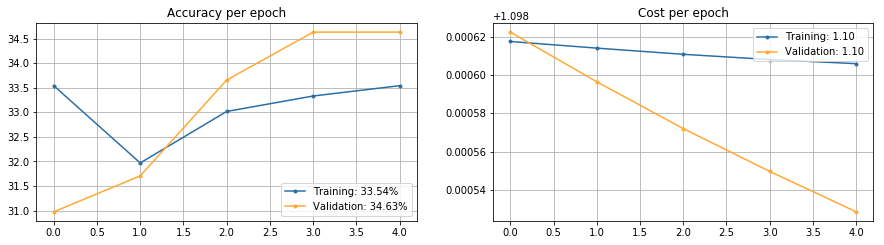

In [24]:
plotter(history)

## Classic Model Building

In [25]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(onetfidf.as_matrix(), tidyData.president, train_size=0.7, random_state=20)

In [26]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xtrain, Ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
print(clf.score(Xtest, Ytest))
print(clf.score(Xtrain, Ytrain))

0.965853658537
0.996855345912


In [28]:
print(clf.predict(Xtest[:10]))

[u'William J. Clinton' u'George W. Bush' u'George W. Bush'
 u'George W. Bush' u'George W. Bush' u'William J. Clinton'
 u'George W. Bush' u'Barack Obama' u'William J. Clinton' u'George W. Bush']


### Pipeline for Cross Validation
The goal here is to search for the optimal hyper-parameters.

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(tidyData.text, tidyData.president, train_size=0.7, random_state=20)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(TfidfVectorizer(), 
                     LogisticRegression(random_state=1))

In [22]:
from sklearn.model_selection import GridSearchCV
pams = {'logisticregression__C': [1000, 2000], 'tfidfvectorizer__ngram_range': [(1,1), (1,2)]}
grid = GridSearchCV(pipe, param_grid=pams, cv=5, n_jobs=2)

In [23]:
grid.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smoo...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)], 'logisticregression__C': [1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [51]:
print(grid.best_params_)
print(grid.score(Xtrain, Ytrain))
print(grid.score(Xtest, Ytest))
print(np.mean(grid.predict(Xtest)== Ytest))

{'logisticregression__C': 2000, 'tfidfvectorizer__ngram_range': (1, 1)}
1.0
0.99512195122
0.99512195122


### Pipeline for PMML

In [56]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(tidyData.text, tidyData.president, train_size=0.7, random_state=20)

In [57]:
from sklearn2pmml import PMMLPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = PMMLPipeline([
    ("TFIDF", TfidfVectorizer()),
    ("Model", LogisticRegression(C=2000, random_state=1))
])
pipe.fit(Xtrain, Ytrain)

PMMLPipeline(steps=[('TFIDF', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [58]:
print(pipe.score(Xtest, Ytest))
print(pipe.score(Xtrain, Ytrain))
print(pipe.predict(Xtest[:10]))

0.99512195122
1.0
['William J. Clinton' 'George W. Bush' 'George W. Bush' 'George W. Bush'
 'George W. Bush' 'William J. Clinton' 'George W. Bush' 'Barack Obama'
 'William J. Clinton' 'George W. Bush']


In [ ]:
from sklearn2pmml import sklearn2pmml
sklearn2pmml(pipe, "Speeches.xml")